In [146]:
#""" Defiendo las librerias """
import numpy as np 
import pandas as pd 
import cv2
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pizza-not-pizza/pizza_not_pizza/food101_subset.py
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2374305.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2415437.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1123352.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2294128.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/215349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/938244.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/444123.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/884964.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2394770.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/901984.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/117282.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1227349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1743531.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/21

# **Clasificación de Imágenes - Bootcamp Nivel Integrador**

# **Descripción del problema:**

Este ejercicio aborda una tarea sencilla de clasificación binaria de imágenes: determinar si una imagen muestra pizza o no ("es pizza" o "no es pizza"). La idea es brindar la oportunidad de explorar un amplio conjunto de problemas en visión artificial y aprendizaje automático, y entrenar un modelo que pueda distinguir con precisión entre imágenes que contienen pizza y aquellas que no.

# **Acerca del DataSet:**

¿A quién no le gusta la pizza? Este conjunto de datos contiene aproximadamente 1966 imágenes. Distribuidas de la siguiente manera:

983 imágenes son de pizza.

983 imágenes no son de pizza.

Originalmente, todas las imágenes se reescalaron para tener una longitud lateral máxima de 512 píxeles.

DataSet: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data

# Cargar el DataSet

In [147]:
# Definimos la ruta donde están almacenadas las imágenes de pizza
pizza_dir = '../input/pizza-not-pizza/pizza_not_pizza/pizza' 

# Definimos la ruta donde están almacenadas las imágenes que NO son pizza
not_pizza_dir = '../input/pizza-not-pizza/pizza_not_pizza/not_pizza'

# Definimos la ruta raíz del conjunto de datos
data_dir = '../input/pizza-not-pizza/pizza_not_pizza'

# Creamos una lista de tuplas (ruta_de_imagen, etiqueta=0) para las imágenes que no son pizza
# Solo se incluyen las imágenes con extensión .jpg
not_pizza = [
    (os.path.join(data_dir, "not_pizza", image), 0)  # 0 representa la clase "no es pizza"
    for image in os.listdir(os.path.join(data_dir, "not_pizza")) 
    if image.split(".")[1] == "jpg"  # Filtramos solo archivos .jpg
]

# Creamos una lista de tuplas (ruta_de_imagen, etiqueta=1) para las imágenes de pizza
# Solo se incluyen las imágenes con extensión .jpg
pizza = [
    (os.path.join(data_dir, "pizza", image), 1)  # 1 representa la clase "pizza"
    for image in os.listdir(os.path.join(data_dir, "pizza")) 
    if image.split(".")[1] == "jpg"  # Filtramos solo archivos .jpg
]

# Unimos ambas listas (pizza y no_pizza) y las convertimos en un DataFrame de pandas
# Cada fila tiene la ruta del archivo y su categoría (0 o 1)
df = pd.DataFrame(not_pizza + pizza, columns=['filename', 'category'])

# Muestra una muestra aleatoria del DataFrame, útil para verificar que todo esté bien cargado
df.sample()


filename  category
1750  ../input/pizza-not-pizza/pizza_not_pizza/pizza...         1

# Análisis Exploratorio de Datos

In [148]:
#DataSet balanceado
print("No of pizza images: ", len(pizza))
print("No of non-pizza images: ", len(not_pizza))

No of pizza images:  983
No of non-pizza images:  983


In [149]:
def plotImages(images_arr, labels):
    # Creamos una figura con una cuadrícula de 4 filas y 5 columnas (20 imágenes en total)
    # figsize define el tamaño de la figura en pulgadas: ancho = 15, alto = 10
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))  

    # Aplanamos la matriz de ejes (axes) para poder iterar fácilmente sobre cada subplot
    axes = axes.flatten()

    # Iteramos sobre las imágenes, etiquetas y ejes al mismo tiempo
    for img, lbl, ax in zip(images_arr, labels, axes):
        ax.imshow(img)         # Mostramos la imagen en el eje correspondiente
        ax.axis('off')         # Ocultamos los ejes (bordes y marcas)
        ax.set_title(lbl)      # Asignamos el título con la etiqueta correspondiente

    # Ajustamos automáticamente los espacios entre subplots para que no se solapen
    plt.tight_layout()

    # Mostramos la figura final con todas las imágenes
    plt.show()


In [150]:
def sample_and_plot_images(train_data, label_names, num_samples):
    # Obtenemos un lote de imágenes y etiquetas desde el generador 'train_data'
    images, labels = next(train_data)
    
    # Convertimos las etiquetas a enteros (por si vienen en formato float o one-hot)
    labels = labels.astype(int)
    
    # Seleccionamos 'num_samples' índices aleatorios sin reemplazo del lote de imágenes
    random_indices = np.random.choice(images.shape[0], num_samples, replace=False)
    
    # Seleccionamos las imágenes correspondientes a los índices aleatorios
    selected_images = images[random_indices]
    
    # Obtenemos los nombres de las etiquetas para las imágenes seleccionadas
    # Por ejemplo, si label_names = {0: "no_pizza", 1: "pizza"}, convertimos de números a texto
    selected_labels = [label_names[label] for label in labels[random_indices]]
    
    # Llamamos a la función plotImages para mostrar las imágenes seleccionadas con sus etiquetas
    plotImages(selected_images, selected_labels)


# Diviendo el DataSet en: Train / Validación / Test 

In [151]:
# Dividimos el DataFrame 'df' en dos partes:
# 80% para entrenamiento y el restante 20% en 'dummy_df' (que luego se usará para validación y prueba)
# 'random_state=42' asegura que la división sea reproducible (misma aleatoriedad cada vez)
train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42, shuffle=True)

# Ahora dividimos el 20% restante ('dummy_df') en:
# 60% para validación → equivale al 12% del total original
# 40% para prueba → equivale al 8% del total original
val_df, test_df = train_test_split(dummy_df, train_size=0.6, random_state=42, shuffle=True)

# Convertimos la columna 'category' de cada subconjunto a tipo cadena (string)
# Esto es útil para que las etiquetas sean compatibles con ciertos modelos y funciones
train_df.category = train_df.category.astype(str)
val_df.category = val_df.category.astype(str)
test_df.category = test_df.category.astype(str)


In [152]:
# Inicializamos un generador de datos que reescala los valores de píxeles a un rango de 0 a 1
# Esto mejora el rendimiento del modelo al normalizar las imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Creamos el generador de datos para el conjunto de entrenamiento
# - x_col: columna con las rutas de las imágenes
# - y_col: columna con las etiquetas (categoría)
# - target_size: redimensiona todas las imágenes a 224x224 píxeles
# - batch_size: número de imágenes por lote (batch)
# - class_mode: 'binary' porque es un problema de clasificación binaria (pizza vs no pizza)
# - shuffle: True para mezclar los datos aleatoriamente en cada época
train_data = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

# Generador para el conjunto de validación, con los mismos parámetros
val_data = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

# Generador para el conjunto de prueba, también con los mismos parámetros
test_data = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)


Found 1572 validated image filenames belonging to 2 classes.
Found 236 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.


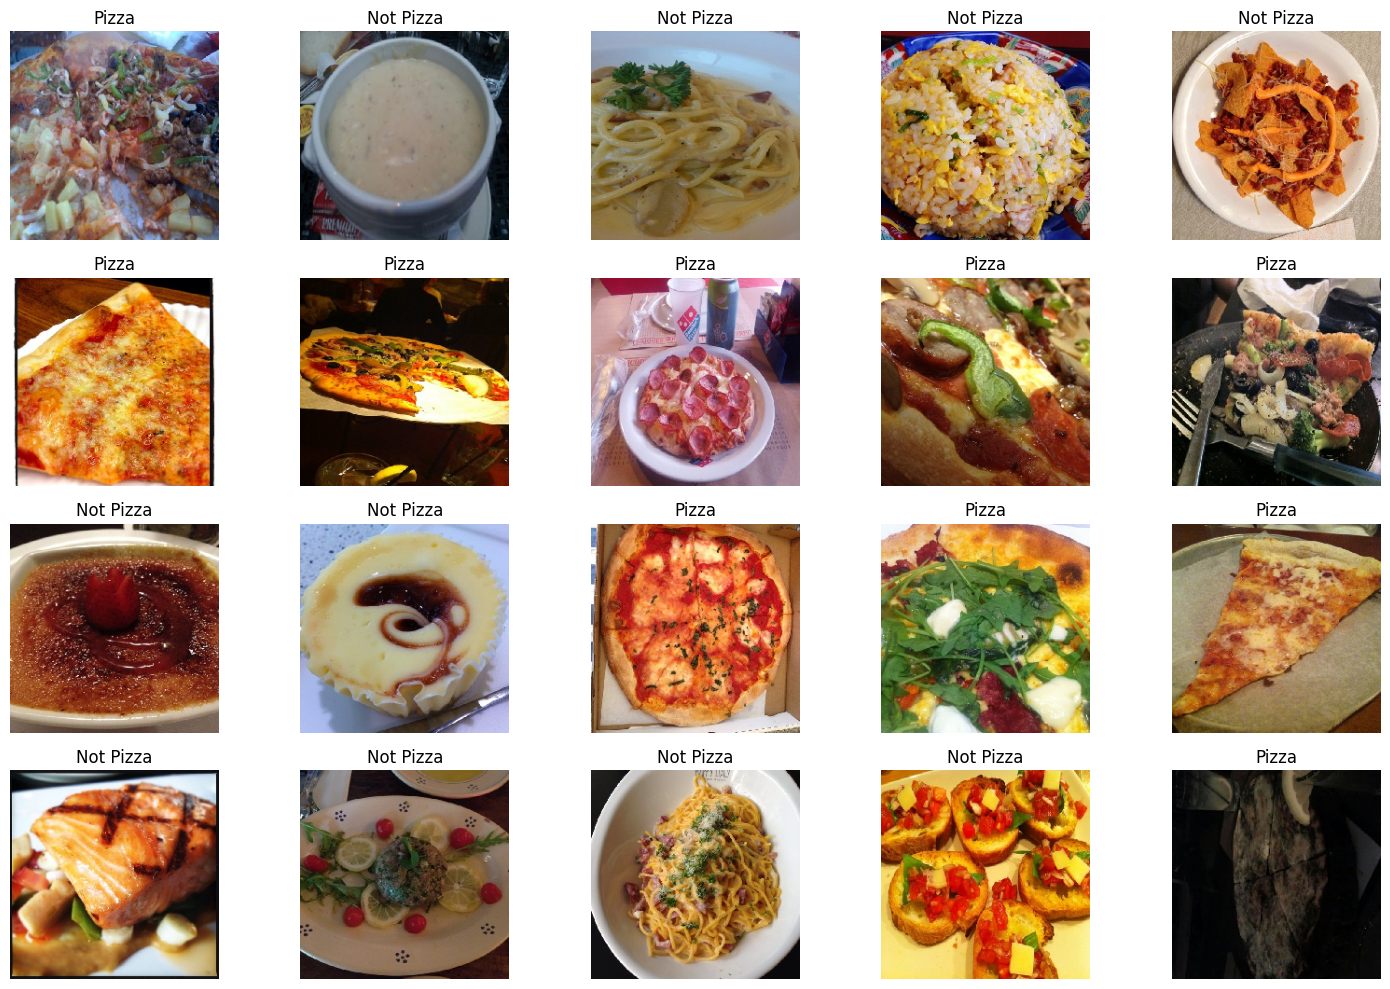

In [153]:
# Muestra una muestra aleatoria de 20 imágenes del conjunto de entrenamiento con sus respectivas etiquetas

# Llamamos a la función 'sample_and_plot_images' que:
# - Toma un batch de imágenes del generador 'train_data'
# - Selecciona aleatoriamente 20 imágenes
# - Asigna nombres a las etiquetas usando el diccionario {0: 'Not Pizza', 1: 'Pizza'}
# - Muestra las imágenes con sus etiquetas usando la función plotImages

sample_and_plot_images(train_data, {0: 'Not Pizza', 1: 'Pizza'}, num_samples=20)


# **Experimento 0: Entrenamiento Base del Módelo**

# Se define un Sequential Model 

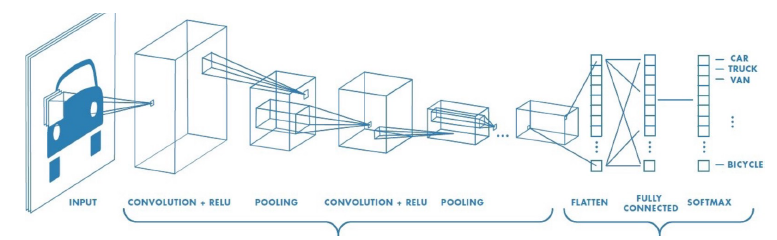

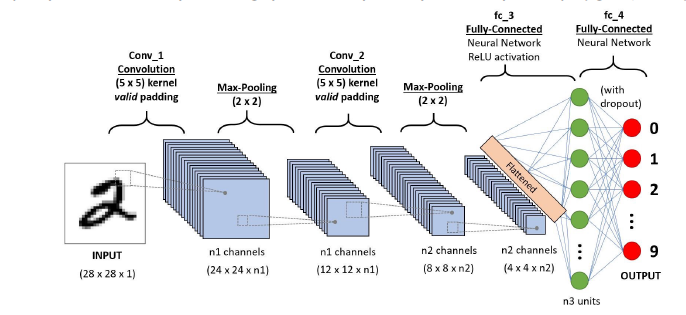

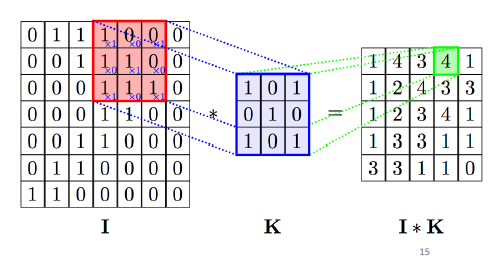

In [154]:
# Definimos un modelo secuencial, donde las capas se agregan en orden una tras otra
model = Sequential([

    # Capa de entrada: recibe imágenes de tamaño 224x224 con 3 canales (RGB)
    Input(shape=(224, 224, 3)),  # Capa de entrada

    # Primera capa convolucional:
    # - Aplica 32 filtros de tamaño 2x2
    # - 'padding=valid' significa que no se agregan bordes (la salida será más pequeña)
    # - 'relu' es la función de activación (rectified linear unit)
    Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),

    # Segunda capa convolucional (igual que la anterior)
    Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),

    # Aplanamos la salida de la última capa convolucional para conectarla a una capa densa
    Flatten(),

    # Capa de salida:
    # - 1 sola neurona con activación sigmoid (ideal para clasificación binaria: pizza / no pizza)
    Dense(1, activation='sigmoid')
])


In [155]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1577088)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │     1,577,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,633 (6.03 MB)

 Trainable params: 1,581,633 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

# **Observaciones del Grupo?**

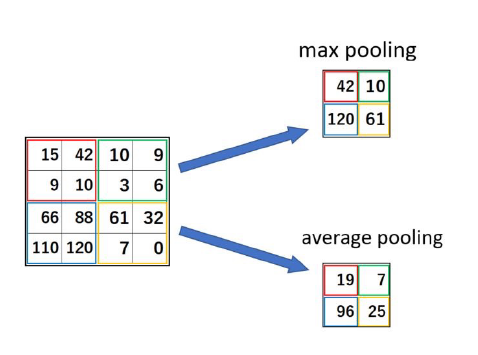

In [156]:
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [157]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.5349 - loss: 9.0302 - val_accuracy: 0.6186 - val_loss: 0.6904
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.6650 - loss: 0.6609 - val_accuracy: 0.5593 - val_loss: 0.7398
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.7967 - loss: 0.5323 - val_accuracy: 0.6780 - val_loss: 0.6361
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9349 - loss: 0.2340 - val_accuracy: 0.6737 - val_loss: 0.7396
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9846 - loss: 0.0899 - val_accuracy: 0.6695 - val_loss: 0.7485
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9989 - loss: 0.0218 - val_accuracy: 0.6441 - val_loss: 0.8075
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.6780 - val_loss: 0.7770
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.6992 - val_

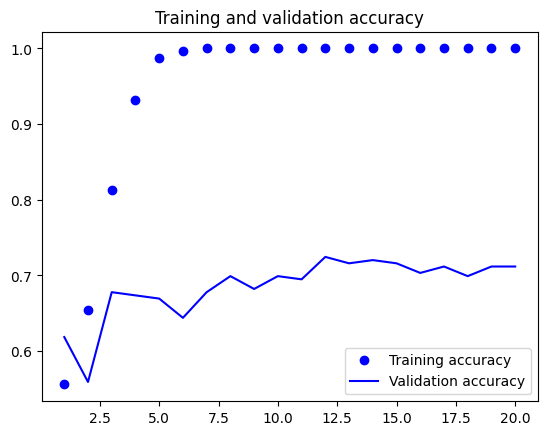

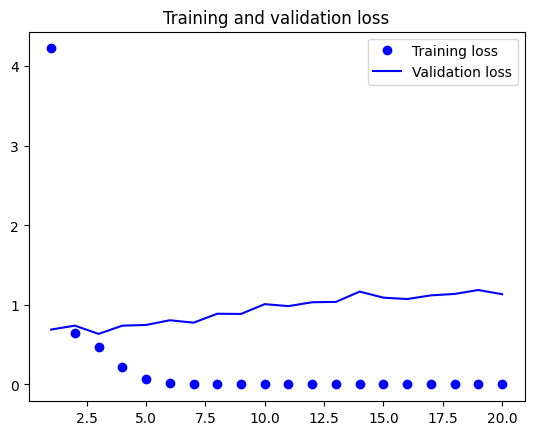

In [158]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [159]:
result = model.evaluate(test_data)
print("Test accuracy:", result[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7094 - loss: 1.0468
Test accuracy: 0.7088607549667358


# Experimento 1: Adicionar Capa MaxPooling 

In [160]:
model = Sequential([
    
    # Input layer: recibe imágenes RGB de tamaño 224x224 píxeles
    Input(shape = (224, 224, 3)),
    
    # Primera capa convolucional:
    # - Aplica 32 filtros de tamaño 2x2
    # - 'valid' padding → no agrega bordes → reduce el tamaño espacial
    # - Activación ReLU introduce no linealidad
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    
    # MaxPooling:
    # - Reduce el tamaño espacial a la mitad (de 223x223 a 111x111)
    # - Ayuda a extraer las características más relevantes
    MaxPool2D(pool_size = 2),
    
    # Segunda capa convolucional:
    # - Igual que la anterior pero aplicada sobre la salida reducida
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    
    # Segundo MaxPooling:
    # - Nuevamente reduce el tamaño espacial (de 110x110 a 55x55)
    MaxPool2D(pool_size = 2),
    
    # Flatten:
    # - Convierte el tensor 3D (55x55x32 = 96,800) en un vector 1D
    # - Este vector se usará como entrada para la capa densa final
    Flatten(),
    
    # Capa densa final:
    # - Tiene 1 neurona con activación sigmoide
    # - Ideal para clasificación binaria (salida entre 0 y 1)
    Dense(1, activation = 'sigmoid')
])


In [161]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 110, 110, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │        96,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,345 (395.88 KB)

 Trainable params: 101,345 (395.88 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [163]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5506 - loss: 0.8174 - val_accuracy: 0.6525 - val_loss: 0.6120
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6818 - loss: 0.5857 - val_accuracy: 0.7669 - val_loss: 0.5500
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.7445 - loss: 0.5101 - val_accuracy: 0.6780 - val_loss: 0.5828
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8253 - loss: 0.4257 - val_accuracy: 0.6737 - val_loss: 0.6773
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.8567 - loss: 0.3491 - val_accuracy: 0.7119 - val_loss: 0.5876
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9178 - loss: 0.2450 - val_accuracy: 0.7415 - val_loss: 0.5634
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9575 - loss: 0.1802 - val_accuracy: 0.7542 - val_loss: 0.5810
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9672 - loss: 0.1207 - val_accuracy: 0.76

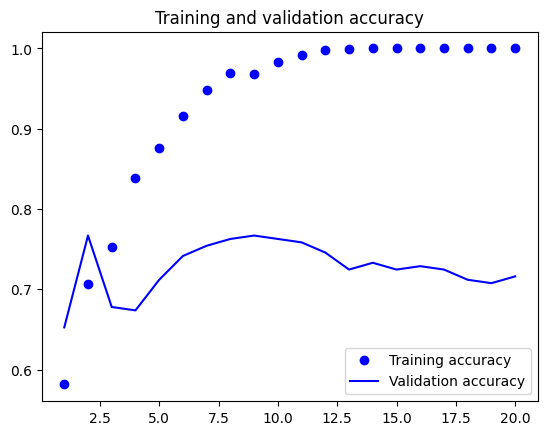

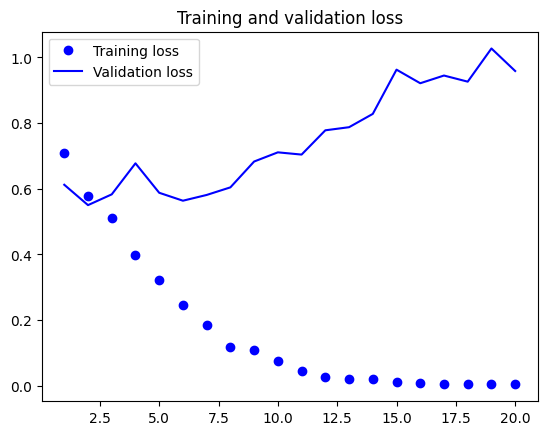

In [164]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [165]:
result = model.evaluate(test_data)
print("Test accuracy:", result[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7715 - loss: 0.8434
Test accuracy: 0.753164529800415


# **Experimento 2 : Entrenando el módelo con Image Augmentation**

In [166]:
# Crea un generador de datos con aumento (ImageDataGenerator) que:
# - Reescala los píxeles dividiéndolos por 255 (de 0-255 a 0-1)
# - Separa el 20% de los datos para validación
# - Aplica aumentos: zoom, rotación, desplazamiento y volteo horizontal
data_gen_augmented = ImageDataGenerator(
    rescale = 1/255.,                   # Normaliza las imágenes
    validation_split = 0.2,            # Reserva el 20% de los datos para validación 
    zoom_range = 0.2,                  # Aplica un zoom aleatorio de hasta 20%
    horizontal_flip = True,            # Voltea horizontalmente las imágenes aleatoriamente
    rotation_range = 20,               # Rota las imágenes aleatoriamente hasta 20 grados
    width_shift_range = 0.2,           # Desplaza horizontalmente hasta un 20%
    height_shift_range = 0.2           # Desplaza verticalmente hasta un 20%
)

# Genera lotes de imágenes aumentadas desde el DataFrame de entrenamiento
# - x_col: columna que contiene los nombres de archivo de las imágenes
# - y_col: columna que contiene las etiquetas
# - target_size: redimensiona las imágenes a 224x224 píxeles
# - batch_size: número de imágenes por lote
# - class_mode: binaria, para clasificación de dos clases
# - shuffle: mezcla aleatoriamente los datos en cada época
train_data_augmented = data_gen_augmented.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

# Hace lo mismo que arriba, pero con el conjunto de validación
val_data_augmented = data_gen_augmented.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

# Hace lo mismo que arriba, pero con el conjunto de prueba
test_data_augmented = data_gen_augmented.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)


Found 1572 validated image filenames belonging to 2 classes.
Found 236 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.


# Visualizar las Imagenes después de aplicar la técnica de Augmentation

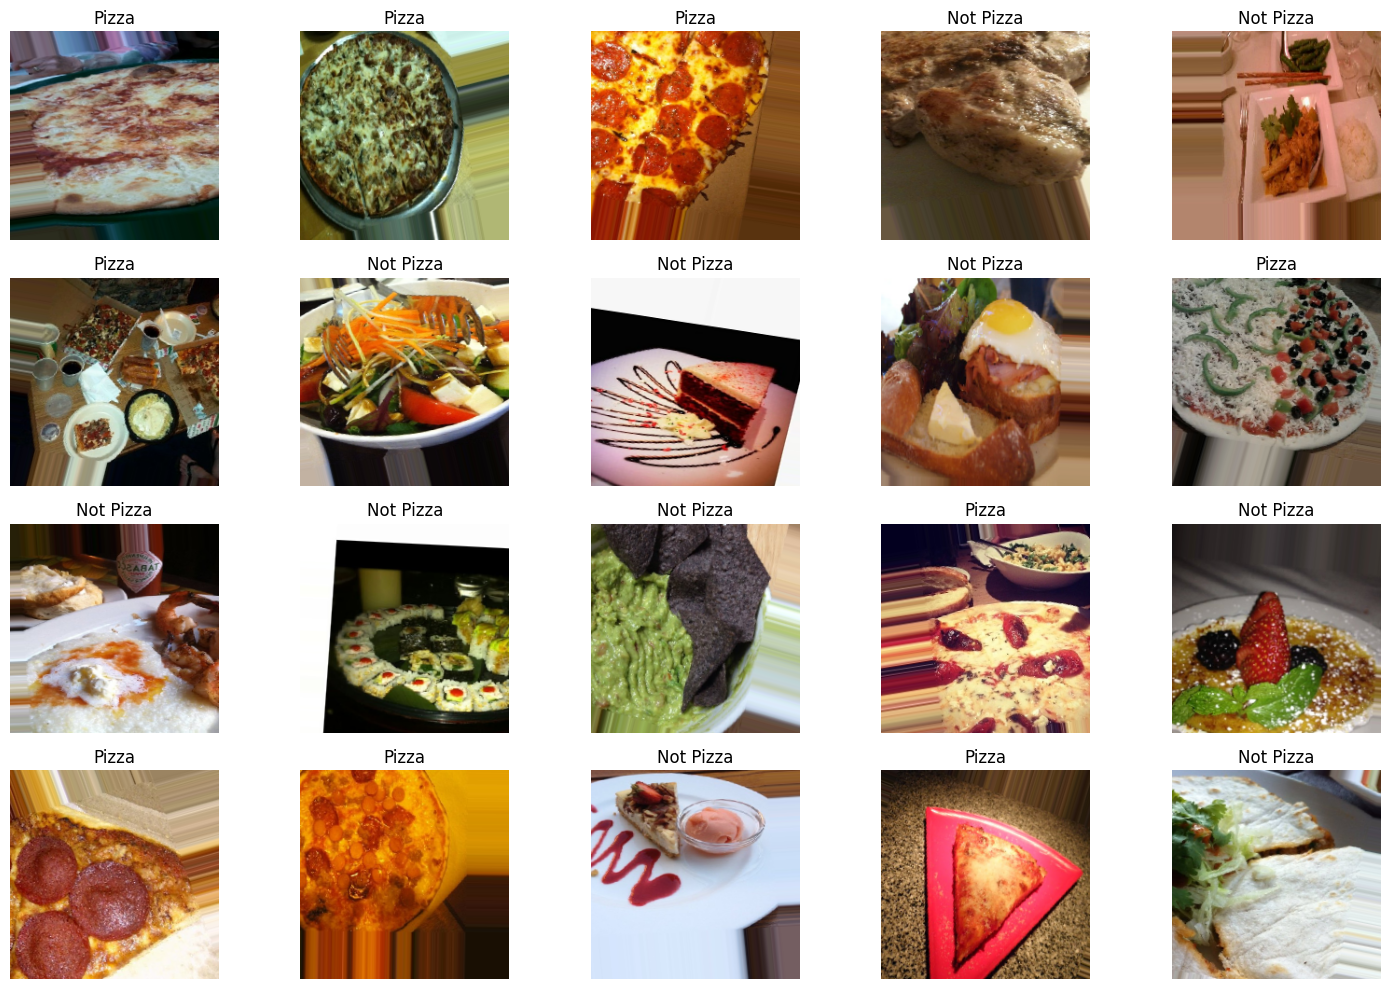

In [167]:
sample_and_plot_images(train_data_augmented, {0: 'Not Pizza', 1: 'Pizza'}, num_samples=20)

In [168]:
model = Sequential([
    Input(shape = (224, 224, 3)),  
    # Capa de entrada: espera imágenes RGB de tamaño 224x224 píxeles

    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),  
    # Primera capa convolucional: aplica 32 filtros de tamaño 2x2
    # Activación ReLU para introducir no linealidad
    # 'valid' significa que no se añade padding (relleno), por lo que la salida será más pequeña

    MaxPool2D(pool_size = 2),  
    # Primera capa de max pooling: reduce las dimensiones espaciales (alto y ancho) a la mitad

    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),  
    # Segunda capa convolucional: otra vez 32 filtros de 2x2 con activación ReLU

    MaxPool2D(pool_size = 2),  
    # Segunda capa de max pooling: vuelve a reducir las dimensiones a la mitad

    Flatten(),  
    # Aplana la salida 3D en un vector 1D para conectar con la capa densa final

    Dropout(0.5),  
    # Capa de regularización: desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento
    # Ayuda a prevenir el sobreajuste (overfitting)

    Dense(1, activation = 'sigmoid')  
    # Capa de salida: una sola neurona con activación sigmoide
    # Ideal para clasificación binaria (por ejemplo, pizza vs. no pizza)
])


In [169]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 110, 110, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │        96,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,345 (395.88 KB)

 Trainable params: 101,345 (395.88 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [171]:
history = model.fit(
    train_data_augmented,
    epochs=20,
    validation_data=val_data_augmented)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.5191 - loss: 0.7355 - val_accuracy: 0.6186 - val_loss: 0.6343
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6281 - loss: 0.6503 - val_accuracy: 0.6653 - val_loss: 0.6076
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6598 - loss: 0.6183 - val_accuracy: 0.5805 - val_loss: 0.6947
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.6502 - loss: 0.6408 - val_accuracy: 0.7161 - val_loss: 0.5938
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6758 - loss: 0.5952 - val_accuracy: 0.7076 - val_loss: 0.5937
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.7192 - loss: 0.5414 - val_accuracy: 0.7288 - val_loss: 0.5409
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 426ms/step - accuracy: 0.6942 - loss: 0.5737 - val_accuracy: 0.7288 - val_loss: 0.5513
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 431ms/step - accuracy: 0.6884 - loss: 0.6026 - val_accuracy: 0.728

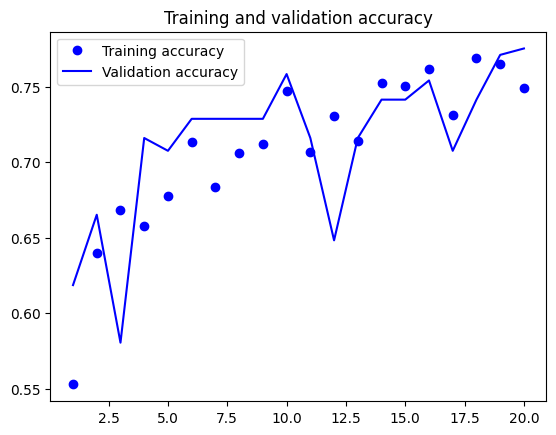

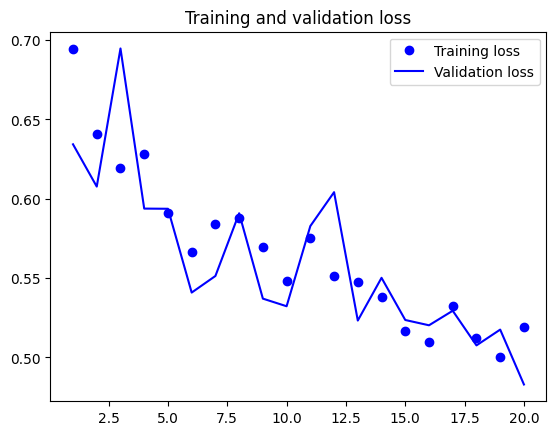

In [172]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [173]:
result = model.evaluate(test_data_augmented)
print("Test accuracy:", result[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 0.7785 - loss: 0.4646
Test accuracy: 0.7848101258277893


# **¿Qué es Data Augmentation?**

Es una técnica que genera nuevas imágenes artificiales a partir de las imágenes originales del dataset, aplicando pequeñas transformaciones como:

Rotaciones

Giros horizontales o verticales

Zoom

Cambios de brillo o contraste

Desplazamientos (shift)

Recortes (crop)

# **🎯 ¿Por qué es importante?**

Evita el sobreajuste (overfitting)
Si el modelo ve siempre las mismas imágenes, puede memorizar los detalles en lugar de aprender patrones generales. Al aumentar los datos, el modelo aprende a generalizar mejor.

Simula variaciones del mundo real
En la vida real, una pizza puede estar girada, recortada, con diferente iluminación, etc. Data Augmentation entrena al modelo para reconocer imágenes aunque no estén exactamente como en el entrenamiento.

Aumenta el tamaño del dataset sin recolectar más datos
A veces no se tienen suficientes imágenes para entrenar una red profunda. Con Data Augmentation, puedes multiplicar el tamaño del conjunto de entrenamiento de forma artificial.

Mejora la robustez del modelo
Un modelo entrenado con data aumentada es más robusto frente a ruidos o cambios en nuevas imágenes.